# Creating Synthetic Populations 

- Inherited from Holmans' PS1_debias.ipynb notebook 



In [2]:
import time
import numpy as np
import scipy.stats as stats
import math
import random
from collections import defaultdict
import MPC_library as MPCL
import healpy as hp
import os
import sys


from collections import Counter


import glob 


import warnings
import warnings
warnings.filterwarnings('ignore')
import kepcart as kc



import matplotlib.pyplot as plt

# Centaur Samples

In [3]:
# M == Mean Anomaly
# E = Eccentric Anomaly
# e = Eccentricity (shape of orbit)
# f = True Anomaly
def M_to_E(M, e, E1=None, iter=200):
    if np.any(E1==None):
        E1=M
    for i in range(iter):
        E0 = E1
        E1 = M + e*np.sin(E0)
    return E1 % (2*np.pi)

def E_to_M(E, e):
    M = E - e*np.sin(E)
    return M % (2*np.pi)

def E_to_f(E, e):
    f = 2.0*np.arctan(np.sqrt((1.+e)/(1.-e)))*np.tan(E/2)
    return f % (2*np.pi)

def f_to_E(f, e):
    E = 2.0*np.arctan(np.sqrt((1.-e)/(1.+e)))*np.tan(f/2)
    return E % (2*np.pi)




In [4]:
def random_vec(nsamp=10):
    u = np.random.uniform(-1,1, size=nsamp)
    incl = np.arccos(u)
    longnode = np.random.uniform(0,2*np.pi, size=nsamp)
    r = np.zeros((nsamp, 3), dtype=np.float)
    r[:,0] = np.sin(incl)*np.cos(longnode)
    r[:,1] = np.sin(incl)*np.sin(longnode)
    r[:,2] = np.cos(incl)
    return r

def random_ortho(nsamp):
    rvecs = random_vec(nsamp)
    pvecs = np.zeros((nsamp,3))
    pvecs[:,0]=rvecs[:,1]
    pvecs[:,1]=-rvecs[:,0]
    p = np.linalg.norm(pvecs,axis=1)
    pvecs=pvecs/p[:,None]
    cvecs=np.cross(rvecs,pvecs)
    theta = np.random.uniform(0,2*np.pi, size=nsamp)
    fvecs = pvecs*np.cos(theta[:,None]) + cvecs*np.sin(theta[:,None])
    return rvecs, fvecs, np.cross(rvecs, fvecs)



In [5]:
#Creates a random sample of objects of size nsamp.
#Most attributes are chosen uniformly, but eccentricity is via a normal distribution defined by muEc, sigmaEc.

def centaur_sample(nsamp=1000000, e_max=0.99):
    r0, pvecs, _ = random_ortho(nsamp)
    x, y, z = r0[:,0], r0[:,1], r0[:,2]
    xn, yn, zn = pvecs[:,0], pvecs[:,1], pvecs[:,2]
    
    
    #normal distribution centered at muEc with std dev sigmaEc
    muEc, sigmaEc = .4, .2
    lowerEc, upperEc = 0, e_max
    TRN = stats.truncnorm((lowerEc-muEc)/sigmaEc, (upperEc-muEc)/sigmaEc, loc=muEc, scale=sigmaEc)
    e = TRN.rvs(size=nsamp)
    
    meananom = np.random.uniform(0,2*np.pi, size=nsamp)
    E = M_to_E(meananom, e, iter=10)
    #muQ, sigmaQ = 30, 10
    #lowerQ, upperQ = 5, 25
    #radiusRandomizer = stats.truncnorm((lowerR - muR)/sigmaR, (upperR-muR)/sigmaR, loc=muR, scale=sigmaR)
    q = np.random.uniform(2, 35, size=nsamp)
    a = q/(1.-e) 
    incl = np.arccos(zn)
    longnode = np.arctan2(xn, -yn)
    
    cosnode=np.cos(longnode)
    sinnode=np.sin(longnode)

    rcosu = x*cosnode + y*sinnode
    rsinu =(y*cosnode - x*sinnode)/zn
    u = np.arctan2(rsinu, rcosu)
    trueanom = E_to_f(E, e)
    argperi = (u - trueanom) % (2*np.pi)
    
    
    return a, e, incl, longnode, argperi, meananom



# Numerical Integration

In [6]:
#Given a set of state variables, this method runs the nbody-r and probe executables to integrate 
#Change nbodyDir to wherever the probe and nbody-r files are.
#Returns a dictionary with times as keys and a position/velocity array as output. 

def createFilesAndIntegrate(states, timestep, steps_per_output, num_outputs) :
    nbodyDir = "/Users/jake/Dropbox/centaurs/nbody_safe/"
    outputDir = "/Users/jake/Dropbox/centaurs/nbody/jakeTests/"
    filestem = "DoIExist_Year_" + str(int(time.time()))#_%fZ")
    # to set up ICs
    # - this is *NOT* the direct input to the n-body integrator
    # - it should more be regarded as a header file / info file 
    #with open(nbodyDir + filestem + '.txt', 'w') as file:
    with open(outputDir + filestem + '.txt', 'w') as file:
        outstring='# These are initial cartesian ecliptic states for a sample of orbits\n'
        outstring+='# These are a replication of the test-particles in %s\n' % nbodyDir + filestem
        outstring+='# Intended to demonstrate tracklet creation at a number of distances\n'
        outstring+='# Generated using pyTrax_Data_Ingest_Example_Synthetic_3.ipynb notebook\n'
        outstring+='#\n'
        outstring+='# x y z xd yd zd\n'
        outstring+='# units are AU and AU/day\n'
        outstring+='#\n'
        file.write(outstring)
        for state in states:
            outstring='particle\n%.16f %.16f %.16f %.16e %.16e %.16e\n' % (state.x, state.y, state.z, state.xd, state.yd, state.zd)
            file.write(outstring)

    # THIS is the main input file 
    # need to add in the planetary positions, etc, at the top of the main input file 
    with open(outputDir + filestem, 'w') as file:
        outstring='time 2454466.5\n' # We should set this to correspond to the Julien Date at the start of 2010
        outstring+='hill_sphere_factor 0.25\n'
        outstring+='dt '+str(timestep)+'\n' # timestep in days 
        outstring+='nupdate '+str(int(steps_per_output))+'\n' # how many timesteps to take before producing output 
        outstring+='noutput 1\n' 
        outstring+='ntotal '+str(int(num_outputs))+'\n' # how many sets of output to produce: we want to run for ~10 years total 
        outstring+='planet_states\n'
        outstring+='particle_states\n'
        outstring+='G 2.959122082322128e-04\n'
        outstring+='Msun 1.0\n'
        outstring+='em_index 0\n'
        outstring+='gr_constant 0.0\n'
        outstring+='quad_constant 0.0\n'
        outstring+='barycentric\n'
        outstring+='sun\n'
        outstring+=' 1.561402529627539e-04  4.953005432015677e-03 -7.105631884623408e-05\n'
        outstring+='-6.389749013486683e-06  6.495964171502198e-07  1.100598619353550e-07\n'
        outstring+='m_planet 1.660114153000000e-07\n'
        outstring+='2.602148208137757e-01 -3.292244628782728e-01 -5.123727708368509e-02\n'
        outstring+='1.659532456067476e-02  1.864190471122602e-02 -3.929871874523593e-07\n'
        outstring+='m_planet 2.447838288000000e-06\n'
        outstring+='-7.178008846563310e-01 -3.564142618684388e-02  4.080959356442847e-02\n'
        outstring+='1.013934063822650e-03 -2.028288042635279e-02 -3.364175614938229e-04\n'
        outstring+='m_planet 3.003489615000000e-06\n'
        outstring+='-1.675444337270498e-01  9.738318399949668e-01 -8.848710649717524e-05\n'
        outstring+='-1.723965496695509e-02 -2.998089479566788e-03  2.014628834321812e-07\n'
        outstring+='m_planet 3.227156038000000e-07\n'
        outstring+='-1.650127782726454e-01  1.579950905388059e+00  3.698226487000504e-02\n'
        outstring+='-1.339404168689282e-02 -2.715126682046571e-04  3.232197353626530e-04\n'
        outstring+='m_planet 9.547919384000000e-04\n'
        outstring+='1.483366733392910e-01 -5.240607574939024e+00  1.838922497888381e-02\n'
        outstring+='7.449937516689820e-03  5.707878757173034e-04 -1.691124368854220e-04\n'
        outstring+='m_planet 2.858859806661000e-04\n'
        outstring+='-8.261542977968610e+00  4.193055697215763e+00  2.558059889927936e-01\n'
        outstring+='-2.822018174472759e-03 -4.987848378405353e-03  1.990803802348707e-04\n'
        outstring+='m_planet 4.366244000000000e-05\n'
        outstring+='1.964046375645850e+01 -4.238756428479231e+00 -2.702098023085751e-01\n'
        outstring+='8.010336315728508e-04  3.661284926651336e-03  3.230110758793685e-06\n'
        outstring+='m_planet 5.151389000000000e-05\n'
        outstring+='2.346585183697751e+01 -1.714470518227547e+01 -7.601640065764197e+00\n'
        outstring+='1.939090244950700e-03 2.304786228786757e-03 8.950850954553373e-04\n'
        file.write(outstring)
        for state in states:
            outstring='particle\n%.16f %.16f %.16f %.16e %.16e %.16e\n' % (state.x, state.y, state.z, state.xd, state.yd, state.zd)
            file.write(outstring)
            
            
        # to run nbody code ...
    #(i) make the command as a string ...
    os.chdir(nbodyDir)
    command = "%snbody-r %s " % (nbodyDir, outputDir +filestem) 
    #(ii) execture the command ...
    os.system(command)


    # N.B. the  output files produced by nbody will look like ...
    #filestem.pb # <<-- Binary file with posns of planets
    #filestem.tb # <<-- Binary file with posns of test particles (what I am interested in)


    # Generate detailed output files using "probe" 
    # probe : can look at the file while running or when finished
    # "case 4" outputs barycentric posn & veloc of all test 
    outfilestem = filestem + "_out"
    command = "%sprobe 4 %s %s " % (nbodyDir , outputDir + filestem , nbodyDir + outfilestem)
    os.system(command)
    
    nbody_dict=defaultdict(list)
    # Find all the output files ...
    # ... then read them all into a dictionary  ...
    # ... key-ed on times 
    for name in sorted(glob.glob( '%s/%s*' % (nbodyDir, outfilestem) )):
        i = 0
        for v in open(name):
            if v.startswith('#'):
                t = float(v.split()[1])-2454466.5 # not permanant solution. FIX THIS! This is a problem!
            else:
                nbody_dict[t].append(tuple(map(float, v.split())))
                i+=1
    # Sorted keys (times)
    sim_times = np.array(sorted(nbody_dict.keys()))
    # Make the data into arrays 
    for key in sim_times:
        nbody_dict[key] = np.array(nbody_dict[key])
    for fn in range(2001):
        command = "rm "+ filestem +"_out_" + str(fn*2+2454466.5)
        os.system(command)
    return nbody_dict

# Chebyshev Approximations

In [7]:
#Fits a piecewise chebyshev polynomial to the first 3 columns of nbody_dict (which should have x,y,z positions 
#and velocities). The maximum error at any point will be less than maxError. Based on some testing, 
#I recomend order 15 and pieces = 1, but feel free to mess around and change this up. 
#The output will be a list of objects. Each object is a list of coordinate functions, and each coordinate function 
#is a dictionary which maps startpoints to an array of polynomial coefficients. For example, if an object is: 
#[{0.0: [1,0,0,0...]}, {0.0: [1,0,0,0...], 2000.0:[2,0,0,0...]}, {0.0: [1.0]}]
#then its X coordinate is always 1, its y coordinate is 1 from time 0 to 2000, and 2 from 2,000 on, 
#and its z coordinate is always 1.

def getPiecewiseChebs (nbody_dict,maxError, order = 15, pieces = 1):
    sim_times = np.array(sorted(nbody_dict.keys()))
    Xchebs = []
    Ychebs = []
    Zchebs = []
    allYs = []
    errors = []
    # loop over the objects in the dictionary ...
    nSamp = len(nbody_dict[sim_times[0]])
    for samp in range(nSamp):
        # Get the positions at each of the times
        ys= np.vstack([nbody_dict[t][samp] for t in sim_times])
        allYs.append(ys)
        x = ys.T[0]
        y = ys.T[1]
        z = ys.T[2]
        Xchebs.append(getGoodApproximation(sim_times, x, order, maxError))
        Ychebs.append(getGoodApproximation(sim_times, y, order, maxError)) 
        Zchebs.append(getGoodApproximation(sim_times, z, order, maxError))
    return ([Xchebs, Ychebs, Zchebs], allYs)


#This gets a piecewise chebyshev polynomial (each piece of some order/degree) which fits the points (x_1, y_1), (x_n, y_n)... with some maximum error.
#If a single piece does not fit the data with the prescribed accuracy, it will bisect itself and try fitting a polynomial to each side.
#Often, when an object has a close encounter with a planet, this ends up repeatedly bisecting to cover one particular small region (near the encounter) very accurately.
#Otherwise, one piece usually fits. The average number of pieces for my centaur sample was about 1.3
def getGoodApproximation(x, y, order, maxError):
    chebCandidate = np.polynomial.chebyshev.chebfit(x, y, order)
    if len(x) <= order:
        return {x[0]: chebCandidate}
    quickEval = np.polynomial.chebyshev.chebval(x, chebCandidate)
    if error(quickEval, y) < maxError: #error threshold
        return {x[0]: chebCandidate}
    else:
        half = int(len(x)/2)
        dict1 = getGoodApproximation(x[:half], y[:half], order, maxError)
        dict2 = getGoodApproximation(x[half:], y[half:], order, maxError)

        dict1.update(dict2)
        return dict1


In [8]:
#Finds the maximum difference between any pair of nth elements of two lists. 
def error(a, b):
    err = 0
    for i in range(len(a)):
        err = max(err, abs(a[i]-b[i]))
    return err


In [9]:
#Evaluates a piecewise chebyshev polynomial at a given time. Returns a list of 3 values. 
def evaluate3DPiecewiseCheb(evalTime, cheb):
    times = [list(i.keys()) for i in cheb]
    for i in range(3):
        times[i].sort()
    iterators = [0,0,0]
    for i in range(3):
        while iterators[i] < len(times[i])-1 and times[i][iterators[i]+1] < evalTime:
            iterators[i] +=1 
    vals = [np.polynomial.chebyshev.chebval([evalTime], cheb[i][times[i][iterators[i]]])[0] for i in range(3)]
    return vals




In [10]:
#Creates a sample of objects, then simulates their motion, and returns chebyshev approximations for the objects' orbits.
def getChebsFromSimulation(nSamp, sim_timestep,num_outputs,total_time,maxError = .0000005):
    errors = ([],[],[],[],[],[],[]) 


    steps_per_output = int((total_time/num_outputs)/sim_timestep) 
    time_per_output = int(total_time/num_outputs) 
    sim_times = np.arange(0, total_time+1, steps_per_output*sim_timestep)  
    
    
    a, e, incl, longnode, argperi, meananom= centaur_sample(nsamp=nSamp, e_max=0.99)
    states = kc.cartesians(len(a), MPCL.Constants.GMsun, a, e, incl, longnode, argperi, meananom)
    nbody_dict = createFilesAndIntegrate(states, sim_timestep, steps_per_output, num_outputs)
    chebs, ys = getPiecewiseChebs(nbody_dict, maxError, 15, 1)
    chebs = np.array(chebs).T
    
    return (chebs)



In [11]:
#Same as getChebsFromSimulation, but instead of returning the objects, writes them to files. 
#Default is 10,000 objects per file, computed 1000 at a time.
def makeChebFiles(start, end, sampleSize=1000, numSamples = 10):
    ender = ''
    for fileNum in [start, end]:
        print()
        print()
        print()
        print('File: ' + str(fileNum))
        print()
        
        #This section is the only important stuff. Runs a simulation of sampleSize objects numSamples times, and 
        #writes the objects to a file named chebs<number>.txt. 
        with open('/Users/jake/Dropbox/centaurs/nbody_safe/chebs'+str(fileNum)+'.txt', 'w') as file:
            for sampleNumber in range(numSamples):
                totalTimer0 = time.time()
                chebs = getChebsFromSimulation(sampleSize, 2.0, 2000.0, 4000.0,.0000005)
                for cheb in chebs:
                    file.write(str(cheb) + '\n')
                
                #Just printing out progress. Not important. 
                totalTimer1 = time.time()
                if sampleNumber % 10 == 1:
                    ender = 'st'
                elif sampleNumber % 10 == 2:
                    ender = 'nd'
                elif sampleNumber % 10 == 3:
                    ender = 'rd'
                else:
                    ender = 'th'
                print('through the ' + str(sampleNumber) + ender + ' part in ' + str(int(totalTimer1-totalTimer0)) + ' seconds')
        
        file.close()
        
def getChebsFromFiles(numFiles):
        obs = []
        for fileNum in range(numFiles):
                with open('/Users/jake/Desktop/savedChebs/chebs'+str(fileNum)+'.txt', 'r') as file:
                        fullStr=file.read()
                        fullStr=fullStr.replace('\n', '')
                        fullStr=fullStr.replace(' ' , '')
                        fullStr=fullStr.replace('\t', '')
                        abc = fullStr.split('][')
                        abc[0] = abc[0][1:]
                        abc[-1] = abc[-1][:-1]
                        for particle in abc:
                                piecewiseChebStrings = particle.split('}{')
                                piecewiseChebStrings[0] = piecewiseChebStrings[0] [1:]
                                piecewiseChebStrings[-1]= piecewiseChebStrings[-1][:-1]
                                obj = []
                                for coordinatePiecewiseCheb in piecewiseChebStrings:
                                        pieces = coordinatePiecewiseCheb.split('),')
                                        pieces[-1]= pieces[-1][:-1]
                                        newDict = {}
                                        for piece in pieces:
                                                key, value = piece.split(':')
                                                key = float(key)
                                                value = value[7:-1]
                                                coefficients = value.split(',')
                                                for i in range(len(coefficients)):
                                                        coefficients[i] = float(coefficients[i])
                                                coefficients = np.array(coefficients)
                                                newDict[key]=coefficients
                                        obj.append(newDict)
                                obs.append(obj)
                file.close()
        return obs

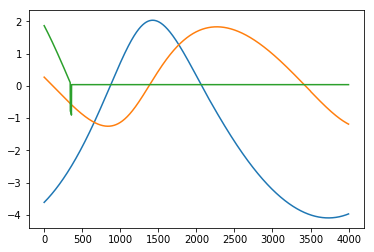

In [217]:
#chebs = getChebsFromFiles(100)
#counter = 0
#minNum=4001
#baddies = []
#for chebnum in range(len(chebs)):
#    keys = list(chebs[chebnum][0].keys())
#    for keyPair in range(len(keys)-1):
#        if keys[keyPair+1]-keys[keyPair] < 17:
#            baddies.append(chebnum)
#            print(keys[keyPair+1]-keys[keyPair])
#            break

i=2
for j in range(i*3, i*3+3):
    x = baddies[j]
#print(chebs[x])
    evalPoints = [evaluate3DPiecewiseCheb(t, chebs[x]) for t in range(4000)]
    ran = range(4000)
    evalX, evalY, evalZ = [evalPoints[i][0] for i in ran], [evalPoints[i][1] for i in ran], [evalPoints[i][2] for i in ran]
    plt.plot(evalZ)
#plt.plot(evalY)
#plt.plot(evalX)
#print(chebs[x][0])
#len(baddies)
#baddies
#print(chebs[x])

In [208]:
#actualBadIndexes = []
#actualBads = [3, 4, 9,10,12,21,37,42,45,54,55,64,65,67,70,72,77,84,91,93,94]
#for i in actualBads:
#    actualBadIndexes.append(baddies[i])
print(baddies[:27])
print(len(actualBadIndexes))

[12393, 22357, 22517, 24518, 30984, 45537, 55445, 70481, 79337, 80593, 84011, 91647, 103809, 104353, 117199, 118243, 120378, 124732, 125107, 128582, 132494, 147951, 148905, 164998, 176452, 187853, 189389]
21


#### Absolute positions to Earth-based observations

In [12]:
#Given a set of objects and a time, this returns a set of vectors from Pan-STARRs to the objects as they appear in
#the sky at that time (speed-of-light delay factored in). 

def getObservationVectorAtTime(atTime, chebyshevs):
    c = MPCL.Constants.speed_of_light
    baseTime = 2454466.5
    offset = 100 #100 days before for speed-of-light buffer
    t0Base = baseTime + offset 
    t0=MPCL.EOP.jdTDB(t0Base)
    nSamp = len(chebyshevs)
    d = np.zeros(nSamp)
    xs = np.zeros(nSamp)
    ys = np.zeros(nSamp)
    zs = np.zeros(nSamp)
    t1Base = t0Base + atTime
    t = MPCL.EOP.jdTDB(t1Base)
    obsPosition = np.array(MPCL.Observatories.getObservatoryPosition('F51', t))
    #print(obsPosition)
    totalTime = 0
    for objNum in range(len(chebyshevs)):
        lightDelay = 0.0
        for i in range(2):
            delayedTime = t - lightDelay
            centaurPosition = evaluate3DPiecewiseCheb(delayedTime-t0+offset, chebyshevs[objNum])
            obsToCentaurVector = centaurPosition - obsPosition
            d = np.linalg.norm(obsToCentaurVector)
            lightDelay = d/c
        x, y, z = obsToCentaurVector
        xs[objNum] = x
        ys[objNum] = y
        zs[objNum] = z 
    return (xs,ys,zs)


In [13]:
#Given a set of piecewise chebs representing objects, this creates a dictionary which maps healPix to objects at a given time.
#Returns a list of lists of objects. The nth list has the integer numbers corresponding to the objects in the nth pixel.
#For example, if chebs is 5 objects and there were only 3 pixels, the dictionary might be: [[3], [2,4], [1,5]]. 
def getHealPixDict(time, chebs, nside):
    nObjects = len(chebs)
    dicts = [[] for i in range(hp.nside2npix(nside))]
    xs, ys,zs= getObservationVectorAtTime(time, chebs)
    for i in range(nObjects):
        pix = hp.vec2pix(nside, xs[i], ys[i], zs[i])
        dicts[pix].append(i)
    return dicts


#Given the healPixDict (with healPixes numbers as keys and an array of objects in that pixel as values), 
#this returns a list of objects in healPixes 
def getObjectsInDisc(healPixDict, nSide, vector, radius):
    pixes = hp.query_disc(nSide, vector, radius, True)
    obsInTheDisc = []
    for pix in pixes:
        obsInTheDisc.extend(healPixDict[pix])
    return obsInTheDisc


#### Get list of exposures from file

In [14]:
#Used to load exposures from amalgamated_unique_exposure_reads.txt into python, 
#and get a list of exposures with tuples containing (JD, ra, dec, and two parts of the filename). 
def getExposureTimesAndAnglesFromFile(filePath):
    exposures = []
    with open(filePath,'r') as file:
        fullText = file.read()
        lines = fullText.split('\n')
        for k in range(len(lines)-2):
            values = lines[k+1].split(',')
            values[1].strip()+values[2].strip()
            for value in range(len(values)):
                values[value] = values[value].strip()
            if len(values) > 6 and not values[6] == 'None':
                exposures.append((float(values[4])-2454466.5, float(values[5]), float(values[6]),values[1], values[2]))

    return exposures


## Generate list of plausible objects 

In [185]:
#Same as getHealPixDict, but reads from a premade file instead of from cheb variables. 
#The n'th element of what is returned is a list of objects in the n'th healpix. 
#The objects are represented by a number, so you'll need to read both the HPdict and the chebs. 
def getHealPixDictFromFile(filePath, fileNum):
    allObjects = []
    with open(filePath + 'HPD'+str(fileNum)+'.txt', 'r') as file:
        fullText = file.read()[2:-2]
        dicts = fullText.split('], [')
        for dictStr in dicts:
            obs = dictStr.split(', ')
            if obs == ['']:
                obs = []
            for objNum in range(len(obs)):
                obs[objNum] = int(obs[objNum])
            allObjects.append(obs)
        file.close()
    return allObjects




In [188]:
#Searches exposures and returns the set within 12 hours of a given time. 
def getExposuresOnDay(exposures, day):
    exposuresOnDay = []
    for exp in exposures:
        if round(exp[0]) == day:
            exposuresOnDay.append(exp)
    return exposuresOnDay


# Reads a healpix dictionary and set of exposures in from files, then writes new files with a list of the objects which 
# might be in each exposure. 
def calculateObjectsNearExposures(exposuresFile, healPixDictPath, outputPath):
    exposures = getExposureTimesAndAnglesFromFile(exposuresFile)
    for day in range (1, 4000):
        HPD = getHealPixDictFromFile(healPixDictPath, day)
        with open('outputPath' + str(day) + '.txt', 'w') as file:
            for exp in getExposuresOnDay(exposures, day):
                theta = exp[1]*2*np.pi/360.
                phi = (exp[2]+90)*2*np.pi/360.
                x,y,z = np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)
                generousObs = getObjectsInDisc(HPD,256, [x,y,z], .0332)
                strictObs = []
                for ob in generousObs:
                    pos = evaluate3DPiecewiseCheb(exp[0], chebs[ob])
                    pos /= np.linalg.norm(pos)
                    if pos[0]*x + pos[1]*y + pos[2]*z > .999450:
                        strictObs.append(ob)
                print(len(strictObs), len(generousObs))
                file.write(str(exp[3]) + ' ' + str(strictObs) + '\n')
                file.close()

In [ ]:
calculateObjectsNearExposures('/Users/jake/amalgamated_unique_exposure_reads.txt', '/Users/jake/Desktop/healPix/', '/Users/jake/Desktop/exposureObjects2/')

To get an entirely new set of objects, just call makeChebFiles. As is, when makeChebFiles is called with parameters a and b, it will create b-a files, each with 10,000 objects. To read chebs in from files, run getChebsFromFiles (will get chebs0.txt up to chebs<x-1>.txt where x is the number you pass in). Both getChebs methods return a list of objects. The HealPix dictionary created from this list will represent each number by its index in the list, so don't modify the list of objects after creating the dictionary.
    
    
To make a HealPix dictionary from a set of files, use getHealPixDictFromFile. HealPix dictionary files should be named HPD<day>.txt, where day ranges from 0 to ~4,000. I used 2454466.5 (Jan 1 2008) as day 0, but I believe the first exposure is early april 2009 and the last exposure is about 3,600 days after, so about 20% of the HealPix dictionaries don't need to exist. 
    
To get a list of likely objects for each exposure, pass an exposures file (amalgamated_unique_exposure_reads.txt), a directory with HealPix dictionaries in it, and an output directory to calculateObjectsNearExposures. 